In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump,load

# 读入数据

In [2]:
df=pd.read_csv('nCoV_100k_train.labled.csv',encoding='utf-8')
df=df.sample(frac=1.0).reset_index(drop=True)
print(df.columns)
print(df.shape)

Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片', '微博视频', '情感倾向'], dtype='object')
(100000, 7)


# 数据清洗

In [3]:
# anomaly data
df=df[df['情感倾向'].isin(['0','1','-1'])]
# duplicate data
df=df.drop_duplicates(['微博id'])
# reset index
df=df.reset_index(drop=True)
print(df.shape)

(99910, 7)


In [4]:
# convert string to int
map_class={'-1':-1,'0':0,'1':1}
df['情感倾向'] = df['情感倾向'].map(map_class)
print(df.shape)

(99910, 7)


-1    16902
 0    57617
 1    25391
Name: 情感倾向, dtype: int64


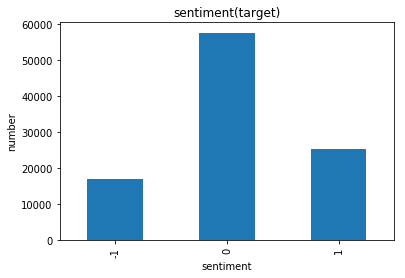

In [5]:
nums_sentiment=df['情感倾向'].value_counts().sort_index()
print(nums_sentiment)
nums_sentiment.plot.bar()
plt.title('sentiment(target)')
plt.xlabel('sentiment')
plt.ylabel('number')
plt.show()

# 准备各数据集

In [6]:
# split train_data, CV_data and test_data
train_per=0.8
CV_per=0.1
train_index=int(df.shape[0]*train_per)
CV_index=int(df.shape[0]*(train_per+CV_per))
train_df=df.iloc[:train_index,:]
CV_df=df.iloc[train_index:CV_index,:]
test_df=df.iloc[CV_index:,:]
print(train_df.shape)
print(CV_df.shape)
print(test_df.shape)

(79928, 7)
(9991, 7)
(9991, 7)


In [7]:
# split features and label
train_X=train_df['微博中文内容']
train_y=train_df['情感倾向']
CV_X=CV_df['微博中文内容']
CV_y=CV_df['情感倾向']
test_X=test_df['微博中文内容']
test_y=test_df['情感倾向']
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(79928,)
(79928,)
(9991,)
(9991,)


# 特征工程

In [8]:
# build count_vect on all weibos
texts_cut=df['微博中文内容'].apply(lambda x:" ".join(jieba.cut(str(x))))
print(texts_cut.shape)
print(texts_cut[0])
count_vect=CountVectorizer(analyzer='word',token_pattern=r'\w{1,}')
count_vect.fit(texts_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Shazam\AppData\Local\Temp\jieba.cache
Loading model cost 0.762 seconds.
Prefix dict has been built successfully.


(99910,)
# 生活 提示 # 【 鞋会 把 病毒 带回家 吗 ？ 】 中国 疾控中心 研究员 冯录 召 ： 新型 冠状病毒 目前 主要 还是 通过 近距离 的 呼吸道 飞沫 传播 ， 或者 接触 传播 。 飞沫 沉降 到 地面 之后 ， 鞋子 就算 有 可能 沾染到 病毒 ， 量 也 非常少 ， 在 日常生活 中 不 需要 对 鞋底 进行 消毒 ， 保持清洁 即可 。 建议 回家 之后 ， 在 门口 换鞋 。 L 央视 新闻 的 微博 视频 ? 展开 全文 c


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)

In [9]:
def textToFeatures(texts,count_vect):
    # word cut
    texts_cut=texts.apply(lambda x:" ".join(jieba.cut(str(x))))
    # vectorize
    texts_count=count_vect.transform(texts_cut)
    return texts_count

In [10]:
train_X_count=textToFeatures(train_X,count_vect)
CV_X_count=textToFeatures(CV_X,count_vect)
test_X_count=textToFeatures(test_X,count_vect)

In [11]:
print(train_X_count.shape)
print(CV_X_count.shape)
print(test_X_count.shape)
print(type(train_X_count))
print(type(train_y))

(79928, 149037)
(9991, 149037)
(9991, 149037)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>


# 模型搭建

## LR

In [12]:
def logisticRegression(X_count,y,max_iter=3000):
    lr=LogisticRegression(max_iter=max_iter)
    lr.fit(X_count,y)
    return lr

## SVM

In [13]:
def SVM(X_count,y,max_iter=5000):
    svc=LinearSVC(max_iter=max_iter)
    svc.fit(X_count,y)
    return svc

## MLP

In [14]:
def MLP(X_count,y,max_iter=10):
    mlp=MLPClassifier(hidden_layer_sizes=(128,64,32),verbose=True,max_iter=max_iter)
    mlp.fit(X_count,y)
    return mlp

## RF

In [15]:
def randomForest(X_count,y,n_trees=100):
    rf=RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_count,y)
    return rf

# 模型训练

In [16]:
lr=logisticRegression(train_X_count,train_y.values)

C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
svc=SVM(train_X_count,train_y.values)

C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [18]:
mlp=MLP(train_X_count,train_y.values)

Iteration 1, loss = 0.67313869
Iteration 2, loss = 0.40227353
Iteration 3, loss = 0.22448753
Iteration 4, loss = 0.13662920
Iteration 5, loss = 0.09879459
Iteration 6, loss = 0.08303651
Iteration 7, loss = 0.07263887
Iteration 8, loss = 0.06713806
Iteration 9, loss = 0.06456697
Iteration 10, loss = 0.06283976


C:\Users\Shazam\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [19]:
rf=randomForest(train_X_count,train_y.values)

# 验证集预测

## LR

In [20]:
lr_predict=lr.predict(CV_X_count)
acc_lr=precision_score(y_true=CV_y,y_pred=lr_predict,average='micro')
print(acc_lr)

0.7221499349414473


## SVM

In [21]:
svc_predict=svc.predict(CV_X_count)
acc_svc=precision_score(y_true=CV_y,y_pred=svc_predict,average='micro')
print(acc_svc)

0.6894204784305875


## MLP

In [22]:
mlp_predict=mlp.predict(CV_X_count)
acc_mlp=precision_score(y_true=CV_y,y_pred=mlp_predict,average='micro')
print(acc_mlp)

0.714442998698829


## RF

In [23]:
rf_predict=rf.predict(CV_X_count)
acc_rf=precision_score(y_true=CV_y,y_pred=rf_predict,average='micro')
print(acc_rf)

0.7177459713742368


In [40]:
best_model=lr

In [28]:
# save the best model
dump(best_model,'best_model.joblib')
#best_model=load('best_model.joblib')
dump(lr,'lr.joblib')
dump(svc,'svc.joblib')
dump(mlp,'mlp.joblib')
dump(rf,'rf.joblib')

['rf.joblib']

# 测试集测试

## best model

In [41]:
test_pred=best_model.predict(test_X_count)
acc_best_model=precision_score(y_true=test_y,y_pred=test_pred,average='micro')
print(acc_best_model)

0.723050745671104


In [32]:
pred_num=[np.sum(test_pred==-1),np.sum(test_pred==0),np.sum(test_pred==1)]
true_num=test_y.value_counts().sort_index()
print(pred_num)
print(true_num.values)

[1389, 6326, 2276]
[1699 5777 2515]


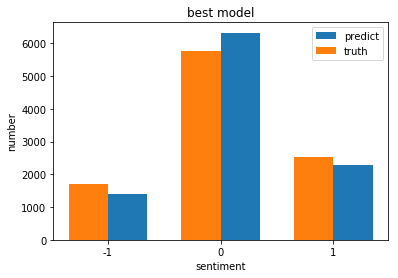

In [33]:
width=0.35
x_position=[width,1+width,2+width]
plt.bar(["-1","0","1"],pred_num,width=width,align='edge',label="predict")
plt.bar([0,1,2],true_num,width=-width,align='edge',label="truth")
plt.legend()
plt.title('best model')
plt.xlabel('sentiment')
plt.ylabel('number')
plt.show()